**Importing Library**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

**Data Cleaning**

In [3]:
# Preprocessing function
def preprocess_text(text):
  text = text.lower() # Lowercase
  text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) # Remove URLs
  text = re.sub(r'\@\w+|\#', '', text) # Remove mentions/hashtags
  text = re.sub(r'[^\w\s]', '', text) # Remove punctuation
  text = re.sub(r'\d+', '', text) # Remove numbers
  # Remove stopwords and lemmatize
  stop_words = set(stopwords.words('english'))
  lemmatizer = WordNetLemmatizer()
  tokens = text.split()
  tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
  return ' '.join(tokens)

**Basic Data Visualizations**

**wordcloud visualizations.**

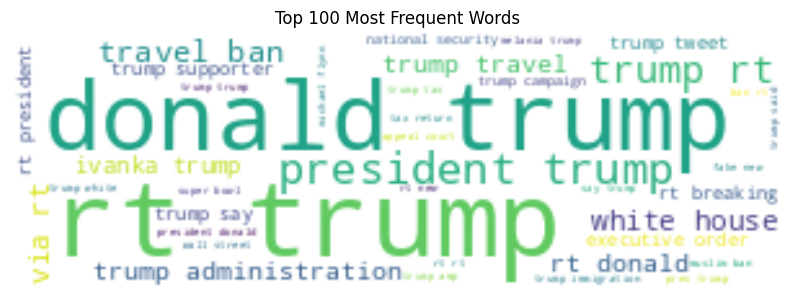

In [4]:
from wordcloud import WordCloud
import pandas as pd

data= pd.read_csv('/content/drive/MyDrive/ai concept/week8/trum_tweet_sentiment_analysis.csv')


# --- Visualization: Word Cloud (Top 100 Words) ---
data['cleaned_text'] = data['text'].apply(preprocess_text)


all_words = ' '.join(data['cleaned_text'])
# Generate WordCloud with only top 100 words
wordcloud = WordCloud(
width=300,
height=100,
background_color='white',
max_words=100 # Limit to top 100 words
).generate(all_words)
# Plot settings
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 100 Most Frequent Words')
plt.show()

In [6]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

# Encode sentiment labels
encoder = LabelEncoder()
data['sentiment_encoded'] = encoder.fit_transform(data['Sentiment'])

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    data['cleaned_text'], data['sentiment_encoded'], test_size=0.2, random_state=42)

# Tokenization
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding
seq_lengths = [len(seq) for seq in X_train_seq]
max_len = int(np.percentile(seq_lengths, 95))

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense

vocab_size = 10000
embedding_dim = 128

# Simple RNN
rnn_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    SimpleRNN(64),
    Dense(1, activation='sigmoid')
])
rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# LSTM
lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    LSTM(64),
    Dense(1, activation='sigmoid')
])
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
]

# Train LSTM (you can train RNN similarly)
history = lstm_model.fit(
    X_train_pad, y_train,
    epochs=10, batch_size=64,
    validation_split=0.2,
    callbacks=callbacks
)

# Evaluation
y_pred = (lstm_model.predict(X_test_pad) > 0.5).astype("int32")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Epoch 1/10
18500/18502 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9209 - loss: 0.1974

18502/18502 ━━━━━━━━━━━━━━━━━━━━ 368s 20ms/step - accuracy: 0.9209 - loss: 0.1974 - val_accuracy: 0.9610 - val_loss: 0.1098
Epoch 2/10
18501/18502 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9673 - loss: 0.0930

18502/18502 ━━━━━━━━━━━━━━━━━━━━ 363s 19ms/step - accuracy: 0.9673 - loss: 0.0930 - val_accuracy: 0.9684 - val_loss: 0.0916
Epoch 3/10
18499/18502 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9757 - loss: 0.0701

18502/18502 ━━━━━━━━━━━━━━━━━━━━ 349s 19ms/step - accuracy: 0.9757 - loss: 0.0701 - val_accuracy: 0.9704 - val_loss: 0.0872
Epoch 4/10
18499/18502 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9810 - loss: 0.0554

18502/18502 ━━━━━━━━━━━━━━━━━━━━ 362s 18ms/step - accuracy: 0.9810 - loss: 0.0554 - val_accuracy: 0.9716 - val_loss: 0.0875
Epoch 5/10
18502/18502 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9849 - loss: 0.0442

18502/18502 ━━━━━━━━━━━━━━━━━━━━ 330s 18ms/step - accuracy: 0.9849 - loss: 0.0442 - val_accuracy: 0.9722 - val_loss: 0.0885
Epoch 6/10
18502/18502 ━━━━━━━━━━━━━━━━━━━━ 349s 19ms/step - accuracy: 0.9880 - loss: 0.0358 - val_accuracy: 0.9714 - val_loss: 0.0962
11564/11564 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step
Accuracy: 0.9704560502668739
Confusion Matrix:
 [[242467   6096]
 [  4836 116626]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98    248563
           1       0.95      0.96      0.96    121462

    accuracy                           0.97    370025
   macro avg       0.97      0.97      0.97    370025
weighted avg       0.97      0.97      0.97    370025



In [ ]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy over Epochs")
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss over Epochs")
plt.legend()
plt.show()


In [ ]:
!pip install gradio


In [13]:
!pip install gradio
import gradio as gr

def predict_sentiment(text):
    # Assuming 'preprocess_text' is the correct preprocessing function
    processed_text = preprocess_text(text)

    # Tokenize using the previously fitted tokenizer
    sequence = tokenizer.texts_to_sequences([processed_text])

    # Pad the sequence
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')

    pred = lstm_model.predict(padded_sequence)
    return "Positive" if pred[0][0] > 0.5 else "Negative"

iface = gr.Interface(
    fn=predict_sentiment,
    inputs="text",
    outputs="text",
    title="Sentiment Predictor",
    description="Enter a tweet to predict its sentiment.",
)

iface.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://0f5c87c189a0e2e239.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
# Example parameters
vocab_size = 10000 # Size of vocabulary
embedding_dim = 128 # Dimension of embedding vectors
max_length = 100 # Maximum length of input sequences
rnn_units = 64 # Number of RNN units
# Build the model
model = Sequential([
# Embedding layer converts word indices to dense vectors
Embedding(input_dim=vocab_size,
output_dim=embedding_dim,
input_length=max_length),
# RNN layer processes the sequence
SimpleRNN(units=rnn_units, return_sequences=False),
# Final dense layer for classification
Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


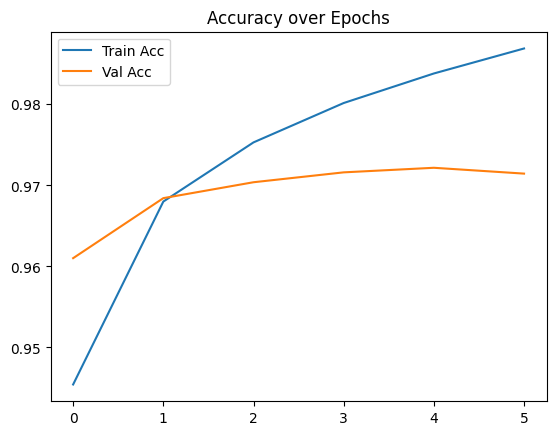

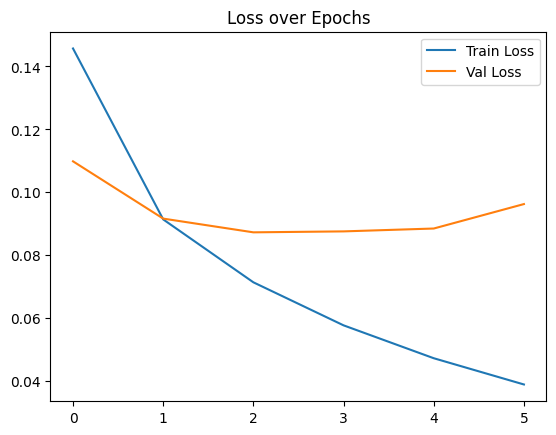

In [12]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy over Epochs")
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss over Epochs")
plt.legend()
plt.show()
